In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from numpy import nan
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
# загружаем данные
# координаты домов
points = gpd.read_file('shapes/coordinates/coordinates.shp', encoding='utf-8').set_index('index')
# данные о домах
data = pd.read_csv('data/housing_data.csv')
data = data.drop(15518)
# карта муниципальных образований
municipalities = gpd.read_file('shapes/municipalities/municipalities.shp', encoding='utf-8')

### Расселение
Рассмотрим вопросы расселения:
- плотность (квадратных метров на человека),
- плотность расселения в коммунальных команатах (комнат на комнат в частных квартирах).

In [3]:
# отбираем интересующие данные из датасета
population = data[['comm_room_num', 'flat_room_num', 'data_livingarea','data_residents']]
population = gpd.GeoDataFrame(population.join(points), geometry='geometry', crs={'init': 'epsg:4326'})

In [4]:
# преобразуем данные
# суммируем число коммунальных комнат
comm_room_sum = population['comm_room_num'].dropna().apply(lambda x: sum([int(xx) for xx in str(x).split(', ')]))
comm_room_sum.name = 'comm_room_sum'
population = population.join(comm_room_sum, how='left')
# суммируем число индивидуальных комнат
flat_room_sum = population['flat_room_num'].dropna().apply(lambda x: sum([int(xx) for xx in str(x).split(', ')]))
flat_room_sum.name = 'flat_room_sum'
# удаляем старые колонки со списками численности комнат
population = population.drop(['comm_room_num','flat_room_num'], axis=1)
population = population.join(flat_room_sum, how='left')

In [5]:
# делаем spatial join: муниципальные образования + дома
population = gpd.sjoin(municipalities, population, op='contains')

__Жилая площадь на жильца__

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


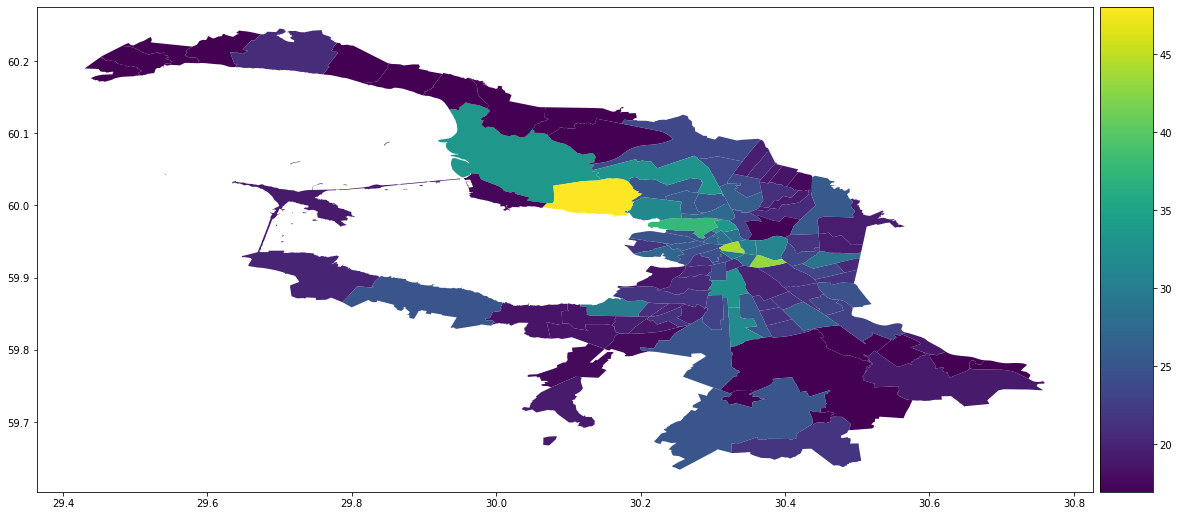

In [6]:
# группируем по муницпалитету
pop_sum = population.groupby('name').sum()
# рассчитываем интересующий параметр
pop_sum['density'] = pop_sum['data_livingarea'] / pop_sum['data_residents']
# аггрегированный датафрейм перестал быть геодатафреймом: джойним его с картой муниципалитетов
pop_sum = municipalities.join(pop_sum, on='name')
pop_sum = gpd.GeoDataFrame(pop_sum, geometry='geometry', crs={'init': 'epsg:4326'})
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot(column='density', ax=ax, legend=True, cax=cax)

__Коммунальных комнат к комнтам в частных квартирах__

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


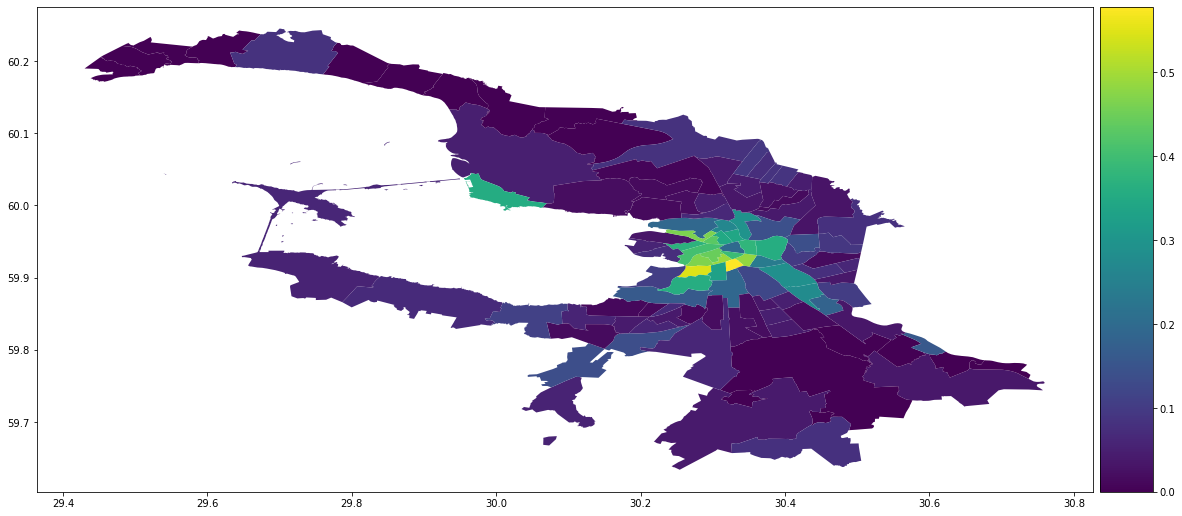

In [7]:
# группируем по муницпалитету
pop_sum = population.groupby('name').sum()
# рассчитываем интересующий параметр
pop_sum['comm_room_density'] = pop_sum['comm_room_sum'] / pop_sum['flat_room_sum']
# аггрегированный датафрейм перестал быть геодатафреймом: джойним его с картой муниципалитетов
pop_sum = municipalities.join(pop_sum, on='name')
pop_sum = gpd.GeoDataFrame(pop_sum, geometry='geometry', crs={'init': 'epsg:4326'})
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot('comm_room_density', ax=ax, legend=True, cax=cax)

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


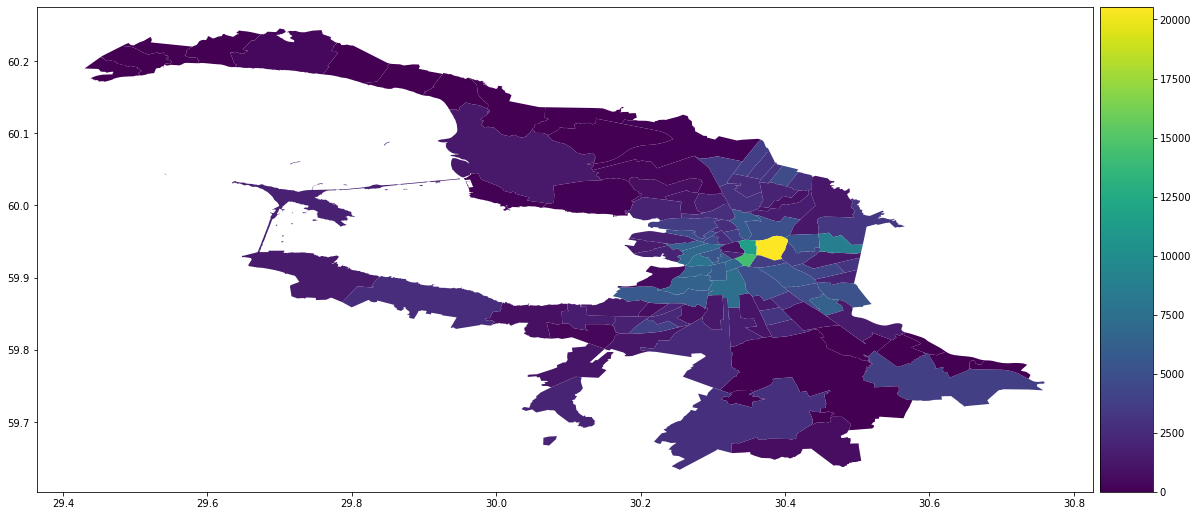

In [8]:
# абсолютное число коммунальных комнат
fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot('comm_room_sum', ax=ax, legend=True, cax=cax)

__Комнат частных квартир на одного жильца__

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


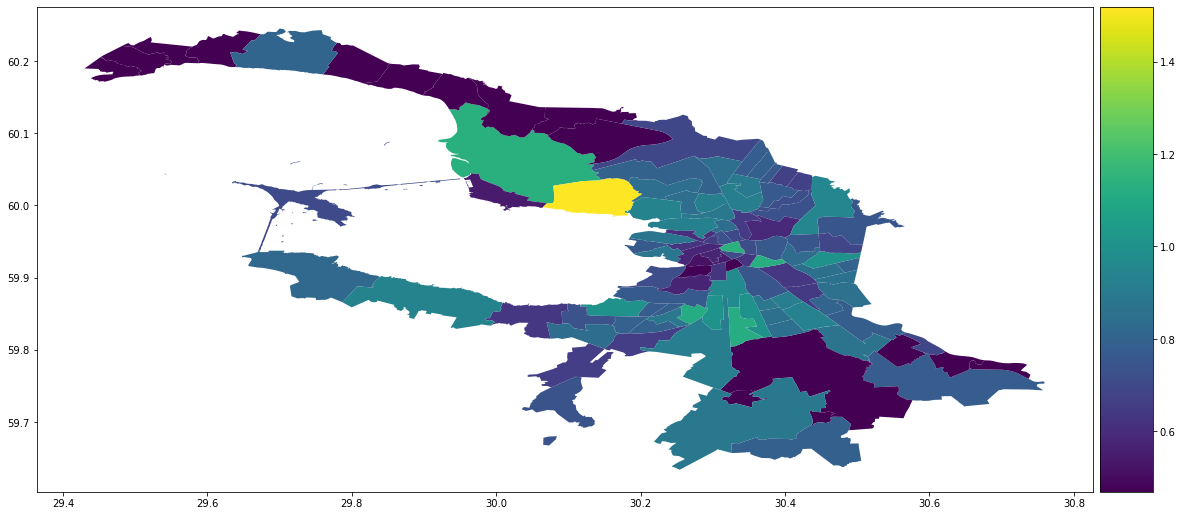

In [9]:
pop_sum = population.groupby('name').sum()
pop_sum['flat_room_density'] = pop_sum['flat_room_sum'] / pop_sum['data_residents']

pop_sum = municipalities.join(pop_sum, on='name')
pop_sum = gpd.GeoDataFrame(pop_sum, geometry='geometry', crs={'init': 'epsg:4326'})

fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot('flat_room_density', ax=ax, legend=True, cax=cax)